## NLP Application with DL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [157]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [158]:
df = pd.read_csv('hepsiburada.zip', encoding="utf-8")

In [159]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243497 entries, 0 to 243496
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  243497 non-null  int64 
 1   Review  243497 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [161]:
df.Rating = df.Rating.map({1:0, 0:1})

# hedef classımızı 1 yapıyoruz.

In [162]:
df.Rating.value_counts()

Rating
0    229821
1     13676
Name: count, dtype: int64

In [163]:
df.Rating.value_counts(normalize=True)

Rating
0    0.943835
1    0.056165
Name: proportion, dtype: float64

## Train Test Split

In [164]:
X = df['Review']
y = df['Rating']

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

## Tokenization

In [166]:
num_words = 15001 # 1 fazlasını yazıyoruz.

tokenizer = Tokenizer(num_words=num_words) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
# Tokenizer fonksiyonu tüm textleri word tokenlerine ayırır.
# num_words hyperparametresi tokenlerin numeric versiyona dönüştürülmesi aşamasında train datasında/corpusunda en fazla geçen ilk 15.000 kelime(token)'nin
# numeric versiyona dönüştürüleceğini diğer tokenlerin ignore edileceğini gösteriyor.
# num_words'e None değeri atanırsa tüm kelimeler/tokenler numeric versiyona dönüştürülür. Ancak num_words'e None atandığında DL modeline data verilirken hata
# döndürür. Bu sebeple num_words'e herzaman integer sayı atanmalıdır. Model kurma aşamasında detaylarına gireceğiz.

# filters hyper_parametresiyle yapılacak olan temizlik işlemlerini düzenleyebiliyoruz. Eğer sayıları da temizlemek istiyorsak filters hyper_parametresine
# sayıları da dahil edebiliriz.

In [167]:
tokenizer.fit_on_texts(X_train)

# fit_on_texts, önce train datasındaki/corpustaki textleri tokenlerine ayırır sonra da tüm unique tokenleri tespit edip kullanım sıklıklarına göre
# numaralandırır. En sık kullanılan tokene 1 numarası verilir.
# num_words= 15001 tanımladığımız için dönüşüm aşamasında 1 ile 15000 arasındaki numaraları alan tokenler kullanılacak diğerleri ignore edilecek.
# Bu tokenlerin kullanım sıklıklarının sıralamasını görebilmek için aşağıda olduğu gibi word_index fonksiyonunu kullanmamız gerekecek.

## Creating word index

In [168]:
tokenizer.word_index

# word_index train datasındaki/corpusundaki tokenleri kullanım sıklıklarına göre sıralar.

{'çok': 1,
 'bir': 2,
 've': 3,
 'ürün': 4,
 'bu': 5,
 'iyi': 6,
 'güzel': 7,
 'için': 8,
 'tavsiye': 9,
 'ederim': 10,
 'daha': 11,
 'ama': 12,
 'da': 13,
 'gayet': 14,
 'hızlı': 15,
 'teşekkürler': 16,
 'aldım': 17,
 'de': 18,
 'ürünü': 19,
 'gibi': 20,
 'yok': 21,
 'uygun': 22,
 'olarak': 23,
 'kaliteli': 24,
 'en': 25,
 'kargo': 26,
 '2': 27,
 'fiyat': 28,
 'elime': 29,
 'kadar': 30,
 'ile': 31,
 'göre': 32,
 'geldi': 33,
 'hepsiburada': 34,
 'var': 35,
 'ben': 36,
 'gerçekten': 37,
 '1': 38,
 'fiyata': 39,
 'gün': 40,
 'sonra': 41,
 'cok': 42,
 'kesinlikle': 43,
 'telefon': 44,
 'biraz': 45,
 'ulaştı': 46,
 'memnun': 47,
 'hiç': 48,
 'değil': 49,
 'hem': 50,
 'kullanışlı': 51,
 '3': 52,
 'mükemmel': 53,
 'oldu': 54,
 'kullanıyorum': 55,
 'önce': 56,
 'sipariş': 57,
 'tek': 58,
 'her': 59,
 'bence': 60,
 'harika': 61,
 'kalitesi': 62,
 'bi': 63,
 'ayrıca': 64,
 '5': 65,
 'teşekkür': 66,
 'olması': 67,
 'fiyatı': 68,
 'ne': 69,
 'herkese': 70,
 'bile': 71,
 'uzun': 72,
 'süper': 73,

In [170]:
len(tokenizer.word_index)
# train datamızda/corpusumuzda toplam 205230 adet unique token var.

205230

## Converting tokens to numeric

In [171]:
X_train_num_tokens = tokenizer.texts_to_sequences(X_train) # X_train'deki unique tokenlere göre numeric versiyona dönüştürüldü
X_test_num_tokens = tokenizer.texts_to_sequences(X_test)   # X_train'deki unique tokenlere göre numeric versiyona dönüştürüldü.Data lekage olmaması için

# texts_to_sequences fonksiyonu ile datamızın her bir document/satırında bulunan tüm tokenleri train datasının word_index'deki kullanım sıklıklarını
# gösteren numaralara göre dönüştürülür (num_words=15001 olduğundan sadece en sık kullanılan ilk 15000 token kullanılacak).

# örnek: "Bu ürün çok güzel tavsiye ederim" yorumu --> Bu: 5, ürün: 4, çok: 1, güzel: 7, tavsiye: 9, ederim: 10 olacak şekilde [5, 4, 1, 7, 9, 10] vektörüne
# dönüştürülür. Bu dönüşümlerin corpusta en sık geçen ilk 15.000 tokene göre yapıldığını unutmayın. Eğer "ederim" tokeni 15.001 'inci veya daha büyük sayıdaki
# bir token olsaydı dönüşüm esnasında "ederim" tokeni ignore edilecek ve elde ettiğimiz vektör [5, 4, 1, 7, 9] şeklinde olacaktı.

In [172]:
np.array(X_train_num_tokens).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (219147,) + inhomogeneous part.

In [ ]:
len(X_train_num_tokens)

In [173]:
X_test[:2]

143605    ürünü yaklaşık 2 senedir kullaniyorum. bu fiya...
133710    Ürünün tüm aparatlarını kullandım . Tereddüt e...
Name: Review, dtype: object

In [174]:
np.array(X_test_num_tokens[:2], dtype="object")
# ilk iki yorumun numeric vektörlerini görüyoruz.

array([list([19, 163, 27, 1047, 623, 5, 39, 25, 22, 669, 966, 225, 9, 10]),
       list([110, 173, 13278, 141, 236, 518, 106, 221, 68, 1146, 1, 435, 976, 4049, 4056, 10805, 15, 81, 3, 411, 1647, 35, 1705, 3, 173, 1073, 923, 1850, 551, 154, 13, 8050, 919, 5065, 5385, 368, 894, 4049, 243, 653, 1, 177, 2267, 8, 113, 5841, 2, 268, 2164, 1188, 13, 212])],
      dtype=object)

## Maximum number of tokens for all documents

In [175]:
len(X_train_num_tokens[105])

# train datasındaki 105. yorum 1 tokenden oluşuyor.

1

In [176]:
len(X_train_num_tokens[106])

# train datasındaki 106. yorum 17 tokenden oluşuyor.

17

In [177]:
len(X_train_num_tokens[6150])

# ML/DL modelleri kendisine verilecek olan tüm datanın aynı boyutlarda olmasını ister. Ancak gördüğünüz gibi tüm yorumların boyutları
# biribirinden farklı.

17

In [178]:
num_tokens = [len(sen_tokens) for sen_tokens in X_train_num_tokens]
num_tokens = np.array(num_tokens)


# öncelikle train corpustaki tüm yorumların boyutlarını bir liste içine alıp num_tokens değişkenine atıyoruz.
# Aggrigation fonksiyonlarını pratik bir şekilde arreylere uygulanabildiği için listeyi arreye dönüştürüyoruz.

In [179]:
num_tokens

# her bir yorumun/documentin kaç tokenden oluştuğunu görüyoruz.

array([45,  9, 22, ...,  8,  6,  5])

In [180]:
num_tokens.max()

# en uzun yorumun 297 tokenden oluştuğunu gördük.
# Tüm dökümanları hangi sayıya sabitlemeliyiz?

297

In [181]:
num_tokens.argmax()

# listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

159025

In [182]:
X_train.iloc[159025]

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

In [183]:
len(X_train_num_tokens[159025])

# Corpusumuzdaki tüm yorumları aynı boyuta getimemiz gerekir. Yorumlarda bir bilgi kaybı/ token kaybı olmaması için aslında
# tüm yorumları en uzun yorumun uzunluğu olan 297'e sabitlenmesi tavsiye edilir. Ancak bu bize çalışma maaliyeti olarak geri dönecektir.
# çok güçlü makinalarınız varsa tabii ki en uzun yorumun boyutuna göre tüm yorumları sabitlemek en mantıklısıdır.
# Ancak, Makinalarımız kuvvetli değilse daha küçük boyutlarda sabitlememiz gerekiyor. Buna karar verirken corpusumuzdaki
# yorumların %95 ve daha üzeri oranlarda bilgi/token kaybı olmayacak (%5 veya daha az token/bilgi kaybı olacak) şekilde sayıyı belirleyebiliyoruz.

297

In [184]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) <= 11)
print(sum(np.array(list) <= 11))
print(sum(np.array(list) <= 11)/len(list))

# Örnek: Corpusumuzda 6 adet yorum olduğunu varsayalım. ilk yorum 5, ikinci yorum 10, üçüncü yorum 8, dördüncü yorum 9, beşinci
# yorum 12 ve altıncı yorum 15 tokenden oluşuyor.

# Tüm yorumları 11 tokene sabitlersem kaç yorumda bilgi/token kaybı olmayacağına bakalım.

# ilk 4 yorumda herhangi bir bilgi/token kaybı olmayacak, ancak 5. yorumda 1 token, 6. yorumda 4 token kaybı olacak.
# np.array(list) <= 11 kodu ile tüm yorumları 11 tokene sabitlediğimizde bilgi/token kaybı olmayan yorumların True olarak,
# bilgi/token kaybı olanların False olarak döndürülmesini sağlıyorum --> [ True  True  True  True False False]
# sum(np.array(list) <= 11) kodu ile öncelikle Truelar 1'e, Falselar 0'a dönüştürülür. Sonra da bu değerler toplanır. Çıkan
# sonuç kaç yorumda bilgi/token kaybı olmadığını bize gösterir.
# [True  True  True  True False False]-->[1 1 1 1 0 0]--> sum([1 1 1 1 0 0])-->4 --> cospusumdaki 6 yorumun 4'ünde bilgi/token
# kaybı yok.
# Elde ettiğimiz 4 sonucunu corpsumuzdaki tüm yorumların sayısına (len([5, 10, 8, 9, 12, 15])-->6) böldüğümüzde bize oran
# olarak kaç yorumda bilgi/token kaybı olmadığını döndürür (4/6 --> 0.67). Biz bu oranın %95 ve üzeri olmasını istiyoruz.

[ True  True  True  True False False]
4
0.6666666666666666


In [29]:
max_tokens = 61

In [30]:
sum(num_tokens <= max_tokens) / len(num_tokens)

# yukardaki örneğimizde olduğu gibi aynı denklemi burda da kuruyoruz. ve max_tokens kaç olursa oran %95'in üzerinde olur.
# Manuel olarak bunun kontrolünü sağlıyoruz. 61 tokene sabitlersem corpusumdaki yorumların %96'sında bilgi/token kaybı
# olmayacağını gördüm. Bu sebeple max_tokens = 61 olarak devam edeceğim.

0.961678690559305

In [31]:
sum(num_tokens <= max_tokens)

# max_tokens = 61 iken train datamdaki/cospusumdaki toplam 219147 yorumun 210749 tanesinde bilgi/token kaybı olmuyor.

210749

In [32]:
len(num_tokens)

# train datamdaki tüm document/satır/yorumların sayısı

219147

## Fixing token counts of all documents (pad_sequences)

In [185]:
X_train_pad = pad_sequences(X_train_num_tokens, maxlen=max_tokens, padding="pre") # padding="pre", dolgu ve kırpmalar baştan yapılır.
X_test_pad = pad_sequences(X_test_num_tokens, maxlen=max_tokens, padding="pre")   # padding="post", dolgu ve kırpmalar sondan yapılır.
                                                                                  # ikisi de denenir hangisi iyi sonuçlar veriyorsa onunla devam edilir.

# pad_sequences fonksiyonu içine yorumların numeric versiyonları ve sabitleneceği uzunluk (maxlen) verilerek tüm yorumlar 61 tokene sabitleniyor.
# Bu işleme padding (dolgulama, takviye etme) işlemi denir. Ancak, adı sizi yanıltmasın bu işlemde sadece dolgu işlemi değil, eksiltme/kırpma işlemi de
# yapılır.
# 61'den daha az tokene sahip yorumlar, yorumun başına ilave edilecek şekilde 0'lar ile doldurulur. Örnek, 50 tokenden oluşan bir yorum 61 tokene
# sabitlenecek şekilde başına 11 adet 0 ilave edilir. (if padding="pre")
# 61'den daha fazla tokene sahip yorumlar, yorumun başından olacak şekilde tokenleri kırpılır. Örnek, 71 tokenden oluşan bir yorum 61 tokene sabitlenecek
# şekilde yorumun başındaki ilk 10 token kırpılır.(if padding="pre")
# 61 tokenden oluşan bir yoruma herhangibir ilave etme veya kırpma işlemi yapılmaz. Olduğu gibi bırakılır.
# 61 tokene sabitlediğimiz yorumlarımızı X_pad değişkenine atıyoruz.

In [186]:
display(X_train_pad.shape)
display(X_test_pad.shape)

# tüm yorumların 61 tokene sabitlendiğini görüyoruz.
# padding işlemine tabi tutulmuş data olduğu anlaşılsın diye X_pad ismini verdik.

(219147, 61)

(24350, 61)

In [187]:
np.array(X_test_num_tokens[800])

array([   4, 2788,   74, 4109,   88,  368,  195,   18, 3168,   33,  153,
       1381, 3758,  277,  210])

In [188]:
len(np.array(X_test_num_tokens[800]))
# test datasındaki 800'üncü yorumun 15 tokenden oluştuğunu görüyoruz.

15

In [189]:
X_test_pad[800]

# padding işlemi sonrası 61 tokene sabitlenecek şekilde yorumun başına 46 adet 0 ilave ediliyor.

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    4, 2788,   74, 4109,   88,  368,  195,   18, 3168,
         33,  153, 1381, 3758,  277,  210])

In [190]:
np.array(X_train_num_tokens[159025])

# şimdide 297 tokenden oluşan train datasındaki/corpusundaki en uzun dökümana/yoruma padding işlemi uygularsak ne olacağına bakalım.

array([  144,     5,  6034,  2262,  1616,   911,   203,     1,     6,
        2938,   164,  4523,   374,  3443,  1531, 13099,     3,  1391,
           1,   493,   280,   140,     1,   493,  3267,  2386,   239,
          21,    82,   760,    31,   212,  4785,  1431,    14,     6,
         471,   607,  2161,    14,    15,   664,  1736,  2166,     3,
         313,   444,   258,    13,   568,   460,   468,  1649,   166,
         648,   509,  3232,  5471,  6629,   604,   620,   153,    38,
         194,   273,   632,   404,   140,    27,    52,    40,   273,
          15,    81,    38,   461,  1670, 12275,  1038,   982,     3,
          96,     2,   317,    35,   134,   170,    40,  2837,     3,
          76,   751,   166,   906,     3,   515,   573,   362,   195,
           1,   493,     3,   172,    82,   255,  6411,    45,   925,
         195,  2075,  7012,   599,  7808,   239,    21,   104,   928,
         135,   391,  1303,  1875,     5,  2156,   569,  1053,  2204,
          27,   335,

In [191]:
X_train_pad[159025]

# Gördüğünüz gibi 61 tokene sabitlenecek şekilde yorumun başındaki ilk 236 token kırpılıyor.

array([ 881, 3415,  534, 1773,  485, 2208,   75,  164,    2,  443,   13,
       1284, 1840, 3302,    5,  822, 7712,  856, 1658, 7573, 3445,   12,
       1284,   31, 3099,  300, 2720,  854, 1052,   39, 1478, 3341,  319,
       1188,   75,  534,   49,  331,  248, 1317,  120,    2, 3341, 7321,
        200,  269,  577, 5857, 1869,   13,   45,  805,  108,    3,  866,
        758, 5709,   49,  106,   77,  886])

## Modelling

In [192]:
model = Sequential()

# Bu işlev, bir modelin sıralı bir şekilde, yani katmanların (layer) birbirini ardışık olarak takip ettiği bir modeli temsil eder.
# Sequential modeli, çıktıları bir sonraki katmana giren katmanları içerir.
# Katmanlar, Sequential modeline add metoduyla eklenir.

In [193]:
embedding_size = 50

# DL modele vereceğimiz her bir tokenin kaç elemanlı/boyutlu bir vektör olmasını istiyorsak burada belirtiyoruz.
# Best practice genelde 50, 100, 300 gibi rakamlar tercih edilse de siz istediğiniz rakamı seçebilirsiniz. Ancak bu sayı ne kadar büyük olursa bize
# çalışma maaliyeti olarak geri dönecektir.

## ANN Modellerinde Tavsiye edilen Nöron Sayısı

Birden fazla hidden layer bulunan **(ANN)** bir deep learning modelinde nöron sayısını planlamak için birkaç farklı yaklaşım bulunmaktadır.

**Giderek azalan nöron sayısı**: İlk gizli katmanda daha fazla nöron kullanılır ve her sonraki katmanda nöron sayısı azaltılır. Bu yaklaşımda, daha önceki katmanlarda daha fazla özellik öğrenilmesini, daha sonraki katmanlarda ise daha az özellik öğrenilemsini sağlar.

**Sabit nöron sayısı**: Her katmanda aynı sayıda nöron kullanılır. Bu yaklaşımda, her katmanın aynı öneme sahip olduğu düşünülür.

**Giderek artan nöron sayısı**: İlk gizli katmanda az sayıda nöron kullanılır ve her sonraki katmanda nöron sayısı arttırılır. Bu yaklaşımda, daha sonraki katmanlarda daha fazla özellik öğrenilemsini sağlar.

Bu yöntemler arasında en iyisini bulmak için deneme-yanılma yapılması önerilir. Ayrıca, gizli katman sayısının, nöron sayılarının, optimizasyon fonksiyonlarının, batch size'ın, vb hiperparametrelerin etkilerini anlamak adına deneyler yaparak, en iyisini seçmek gerekir.

**Hipotez olarak, ilk katmanlarda daha fazla nöron kullanılmasının, daha geniş bir özellik alanını kapsamasına ve dolayısıyla daha iyi bir özellik öğrenmesine neden olabileceği söylenebilir. Ancak performans için her zaman en iyi seçenek olmayabileceği için, yapacağınız denemelerle hepsini deneyip en iyi sonucu elde etmeniz önerilir.**

## RNN Modellerinde Tavsiye edilen Nöron Sayısı:

**Giderek azalan nöron sayısı:** İlk LSTM&GRU katmanında daha fazla nöron kullanılır ve her sonraki katmanda nöron sayısı azaltılır. Bu yaklaşımda, daha önceki katmanlarda daha fazla özellik öğrenilmesini, daha sonraki katmanlarda ise daha az özellik öğrenilmesini sağlar.

LSTM ve GRU layerlarının "return_sequences" hyper_parametresi True olarak düzenlenirse aşağıda görülen tüm time steplerdeki hidden stateler bir sonraki LSTM/GRU layerına beslenir. Eğer False olarak düzenlenirse sadece son hidden state sonraki layera beslenir.

 Eğer bir LSTM/GRU layerını takip eden layer LSTM/GRU layerı ise  "return_sequences"  hyper_parametresi mutlaka True olarak düzenlenmeli aksi taktirde model çalışmaz ve hata döndürür.

 Eğer bir LSTM/GRU layerını takip eden layer Dense layerı ise  "return_sequences"  hyper_parametresi mutlaka False olarak düzenlenmeli aksi taktirde model çalışmaz ve hata döndürür.

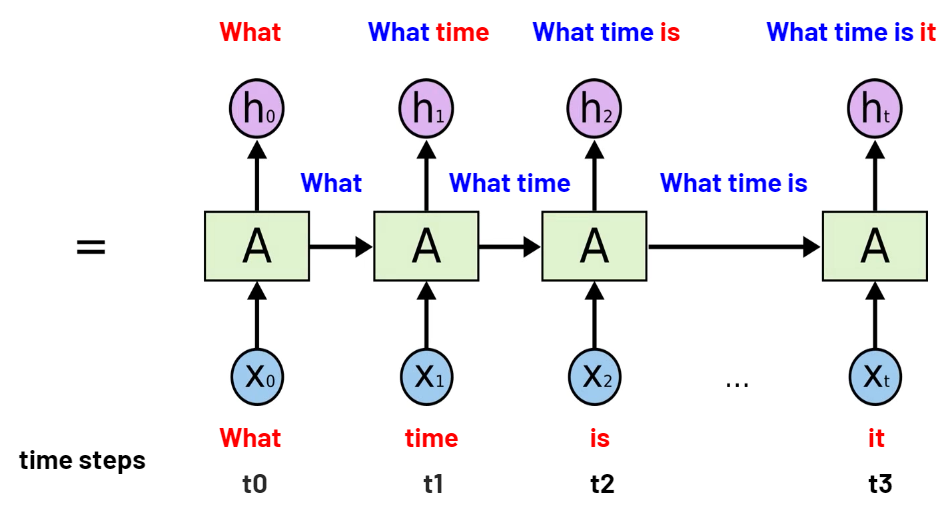

In [194]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    #input_length=max_tokens
                    ))

# Embedding layer NLP modellerinde kullanılan bir layer olup 3 boyutlu bir tensörden oluşur.
# 1'inci boyutu train setindeki toplam yorum sayısı.
# 2'inci boyutu her bir yorumun kaç tokenden oluştuğu (max_tokens).
# 3'üncü boyutu her bir tokene ait word embeddingin kaç elemanlı bir vektörden oluştuğu (embedding_size).
# Tokenler numeric versiona dönüştürülürken train corpusunda en sık kullanılan ilk 15000 token kullanıldığından, hem train hem de predicit aşamasında
# sadece train corpusunda en sık geçen ilk 15000 tokenin kullanılıp kullanılmadığını model kontrol edebilsin diye Embedding layera imput_dim = num_words
# düzenlemesini yapıyoruz.
# Eğer imput_dim'i 15.000'den daha küçük bir sayı yaparsanız (10000 gibi) o zaman model corpusta en sık kullanılan ilk 10000 token ile eğitim ve
# prediction yapar.

model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))

# return_sequences=False modelin sadece son zaman adımındaki (t_n) hidden_state'i bir sonraki layera aktarır. defaultu False'dur.
# return_sequences= True,  modelin tüm zaman adımlarındaki (t_0, t_1, t_2 .....t_n gibi) hidden_state'leri bir sonraki LSTM, GRU layerlarına aktarır.
# Bu sayede  model tüm cümleyi aklında tutmaya çalışır. Bir LSTM/GRU layerından sonra yine bir LSTM/GRU layerı geliyorsa return_sequences=True olarak
# ayarlanmalıdır yoksa model hata döndürür. Ancak, sonraki layer dense layer ise return_sequences=False düzenlenmelidir aksi durumda model yine hata
# döndürür. Çünkü Dense layerlar sadece tek bir hidden_state ile çalışır.
model.add(Dropout(0.2))

model.add(GRU(units=25, return_sequences=True))
model.add(Dropout(0.2))
# sonraki layer GRU layer olduğundan return_sequences=True olarak düzenledik.

model.add(GRU(units=12, return_sequences=False))
# sonraki layer dense layer olduğundan return_sequences=False olarak düzenledik.


model.add(Dense(1, activation='sigmoid'))

In [195]:
# Dropout işlemi sırasında belirlenen oran, ortalama olarak kaç nöronun kapatılacağını ifade eder. Örneğin dropout(0.5) işlemi sırasında, her iterasyonda
# nöronların %50'si rastgele olarak kapatılır.Ancak bu oran her iterasyonda tam olarak aynı olmayabilir. Örneğin bir iterasyonda 0.3 , diğer iterasyonda 0.7
# olabilir ama ortalaması her zaman 0.5 olur.
# Bu nedenle oran her iterasyonda tahmin edebileceğiniz gibi değişebilir.

In [196]:
optimizer = AdamW(learning_rate=0.01) #AdamW

In [197]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

# compile (derleme) optimizasyon parametlerini düzenlediğimiz yerdir.
# compile parametreleri DL modelinin optimizosyon işlemlerinde kullanacağımız gradient descent algortimasının seçimi, loss functionın belirlenmesi
# ve optimizasyon işlemleri sırasında takip edilecek metricleri içerir. Detayları aşağıda olduğu gibidir.
# loss: Modelin optimize edilmesi için kullanılacak kayıp fonksiyonu. Örnek olarak, classification :binary_crossentropy veya categorical_crossentropy,
# regression:mse gibi.
# optimizer: Modelin ağırlıklarını optimize etmek için kullanılacak olan optimizasyon algoritması. Örnek olarak, SGD, Adam veya RMSprop gibi.
# metrics: Modelin performansını değerlendirmek için kullanılacak olan metrikler. Örnek olarak, accuracy, precision veya recall gibi.

In [201]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall",
                           mode="max",
                           patience = 1,
                           restore_best_weights=True,
                           verbose=1)

In [202]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train) #class_weight={0:1, 1:10}
pd.Series(classes_weights).unique()

array([0.52975261, 8.90262431])

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

In [203]:
model.fit(X_train_pad,
          y_train,
          epochs=10,
          batch_size=512,
          sample_weight=classes_weights,
          validation_data=(X_test_pad, y_test),
          callbacks=[early_stop])

Epoch 1/10
429/429 [==============================] - 109s 254ms/step - loss: 0.3007 - recall: 0.8694 - val_loss: 0.2131 - val_recall: 0.8801
Epoch 2/10
429/429 [==============================] - 117s 274ms/step - loss: 0.1903 - recall: 0.9331 - val_loss: 0.1403 - val_recall: 0.8129
Epoch 2: early stopping


https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

In [204]:
model.summary()
# embedding_size * num_words ==> 50 * 15001 ==> 750050

# 3 x (n2 + nm + 2n) m= input, n= output
# (50*50 + 50*50 + 2*50)*3 = 15.300 ==> m = 50, n = 50
# (25*25 + 50*25 + 2*25)*3 = 5775   ==> m = 50, n = 25
# (12*12 + 25*12 + 2*12)*3 = 1404   ==> m = 24, n = 12
# (12+1)*1 = 13 ==> (input+bias)*output

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 50)          750050    
                                                                 
 dropout_24 (Dropout)        (None, None, 50)          0         
                                                                 
 gru_24 (GRU)                (None, None, 50)          15300     
                                                                 
 dropout_25 (Dropout)        (None, None, 50)          0         
                                                                 
 gru_25 (GRU)                (None, None, 25)          5775      
                                                                 
 dropout_26 (Dropout)        (None, None, 25)          0         
                                                                 
 gru_26 (GRU)                (None, 12)               

## Model evaluation

In [205]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,0.300749,0.869353,0.213061,0.880117
1,0.190336,0.933133,0.140294,0.812865


<Axes: >

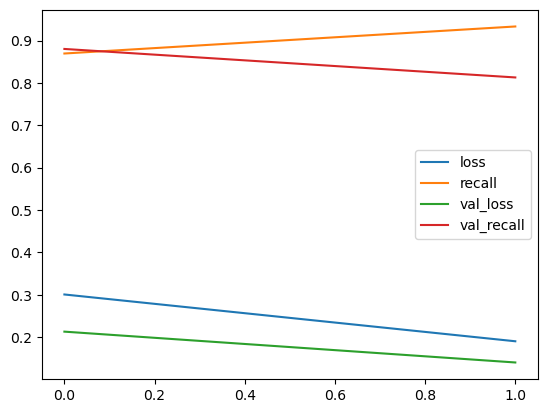

In [206]:
model_loss.plot()

In [207]:
model.evaluate(X_test_pad, y_test)

761/761 [==============================] - 9s 11ms/step - loss: 0.2131 - recall: 0.8801


[0.2130608856678009, 0.8801169395446777]

In [208]:
model.evaluate(X_train_pad, y_train)

6849/6849 [==============================] - 74s 11ms/step - loss: 0.1879 - recall: 0.9494


[0.18792471289634705, 0.9493825435638428]

In [209]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

y_pred = model.predict(X_test_pad) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

761/761 [==============================] - 9s 11ms/step
[[21279  1703]
 [  164  1204]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     22982
           1       0.41      0.88      0.56      1368

    accuracy                           0.92     24350
   macro avg       0.70      0.90      0.76     24350
weighted avg       0.96      0.92      0.94     24350



In [210]:
y_train_pred = model.predict(X_train_pad) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

6849/6849 [==============================] - 70s 10ms/step
[[193449  13390]
 [   623  11685]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    206839
           1       0.47      0.95      0.63     12308

    accuracy                           0.94    219147
   macro avg       0.73      0.94      0.80    219147
weighted avg       0.97      0.94      0.95    219147



761/761 [==============================] - 8s 10ms/step


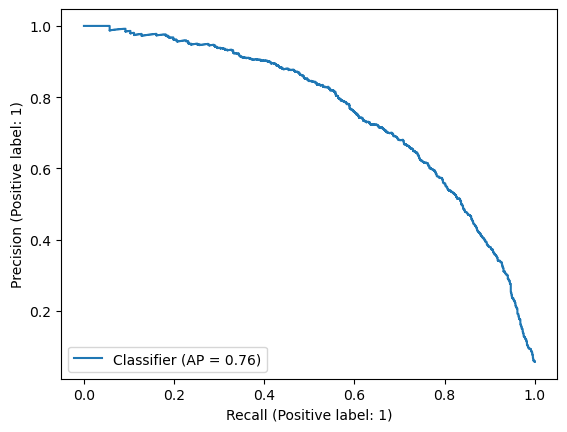

In [211]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test_pad)

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.show();

In [212]:
from sklearn.metrics import precision_recall_curve, average_precision_score

average_precision_score(y_test, y_pred_proba)

0.7578317802167172

## Scores without sample_weight

Test set

                precision    recall  f1-score   support

           0       0.98      0.99      0.98     45965
           1       0.72      0.63      0.67      2735

    accuracy                           0.97     48700
   



 Train set

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    183856
           1       0.87      0.80      0.84     10941

    accuracy                           0.98    194797
   

## Model Saving

In [213]:
model.save('/content/drive/MyDrive/review_hepsiburada.h5')

C:\Users\nurda\anaconda3\envs\NlpEnv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Loading Model

In [ ]:
#from tensorflow.keras.models import load_model
#model_review = load_model('/content/drive/MyDrive/review_hepsiburada.h5')

## Tokenizer Saving

In [214]:
import joblib

# Tokenizer'ı kaydet
joblib.dump(tokenizer, '/content/drive/MyDrive/tokenizer.joblib')

#pickle veya joblib kütüphanelerini kullanarak tokenizar algirtimamızı drive kaydedebiliriz.

['/content/drive/MyDrive/tokenizer.joblib']

## Loading Tokenizer

In [215]:
#import joblib

# Tokenizer'ı yükle
loaded_tokenizer = joblib.load('/content/drive/MyDrive/tokenizer.joblib')

#pickle veya joblib kütüphanelerini kullanarak tokenizar algirtimamızı drive'dan çağırabiliriz.

## Predicton

In [216]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım."
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "üründe sıkıntı var"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik."
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün.Teşekkürler '
review15 = 'telefon kesinlikle bu parayı hak etmiyor. yeni hiç bir özelliği yok. ancak küçük ekran sevenler için iyi bir telefon'
review16 = 'müthiş bir telefon ama bu parayı hak etmiyor'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16]

# 16 tane yorum için prediction alacağız.

In [217]:
tokens = tokenizer.texts_to_sequences(reviews)

# Öncelikle predict edeceğimiz textleri train datasında olduğu gibi datamızda en fazla kullanılan 15000 tokene göre  numeric versiona dönüştürüyoruz.
# train datasında en sık kullanılan ilk 15000 tokene göre dönüşümler yapıldığından ilk 15000 token dışında kalan tokenler predict aşamasında ignore edilir.

In [218]:
np.array(tokens, dtype="object")

array([list([1, 146, 70, 9, 10]), list([73, 4]),
       list([103, 2, 1031, 2290, 1459, 5, 19, 5, 1784, 11674]),
       list([4235, 11684]),
       list([556, 61, 82, 26, 1, 445, 33, 3, 4, 1031, 2290, 37]),
       list([48, 1103, 6142, 20, 49]),
       list([177, 746, 7522, 82, 261, 105, 326]),
       list([48, 5, 30, 177, 2, 1742, 1235, 4, 1755, 4934, 84]),
       list([74, 2, 28, 111, 19]), list([636, 20, 859]),
       list([392, 178, 1007, 513]), list([453, 147, 35]),
       list([6953, 317, 62, 1, 177, 376, 475, 286, 6350, 1380, 41, 9533, 771]),
       list([38, 40, 20, 108, 2, 161, 29, 149, 3, 5, 2891, 73, 2, 4, 9, 10, 1191, 2394, 103, 113, 2024, 11, 103, 1155, 176, 12442, 4, 16]),
       list([44, 43, 5, 1242, 490, 733, 136, 48, 2, 239, 21, 82, 116, 166, 1620, 8, 6, 2, 44]),
       list([585, 2, 44, 12, 5, 1242, 490, 733])], dtype=object)

In [219]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens, padding="pre")
tokens_pad.shape

# tüm yorumları train datasında olduğu 61 tokene sabitliyoruz.

(16, 61)

In [220]:
prob = model.predict(tokens_pad)
prob

1/1 [==============================] - 0s 31ms/step


array([[0.02814229],
       [0.05426291],
       [0.9870631 ],
       [0.16934824],
       [0.9227518 ],
       [0.98510146],
       [0.5603452 ],
       [0.9714636 ],
       [0.10645006],
       [0.96628636],
       [0.04017789],
       [0.4818665 ],
       [0.98063165],
       [0.2428989 ],
       [0.95970064],
       [0.8009449 ]], dtype=float32)

In [221]:
[i[0] for i in prob]

[0.02814229,
 0.054262906,
 0.9870631,
 0.16934824,
 0.9227518,
 0.98510146,
 0.5603452,
 0.9714636,
 0.10645006,
 0.96628636,
 0.04017789,
 0.4818665,
 0.98063165,
 0.2428989,
 0.95970064,
 0.8009449]

In [222]:
pred = (model.predict(tokens_pad) >0.5).astype("int")
pred

1/1 [==============================] - 0s 64ms/step


array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]])

In [223]:
[i[0] for i in pred]

[0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]

In [224]:
pd.set_option('display.max_colwidth', None) # None/-1 ile hücre genişliğini en uzun yoruma/satıra göre ayarlıyor.
my_dict = {"Review":reviews, "prob":[i[0] for i in prob], "classes":[i[0] for i in pred]}
pd.DataFrame(my_dict)

# DataFrame tüm featurların aynı boyutta olmasını istediğinden prob ve classes featurlarını 2 boyuttan tek boyuta düşürüyoruz.
# Bu sayede tüm featuraler aynı boyutta olmuş oluyor.

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.028142,0
1,süper ürün,0.054263,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.987063,1
3,kelimelerle tarif edilemez,0.169348,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.922752,1
5,hiç resimde gösterildiği gibi değil,0.985101,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım.,0.560345,1
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.971464,1
8,tam bir fiyat performans ürünü,0.106450,0
9,beklediğim gibi çıkmadı,0.966286,1
